In [1]:
import pandas as pd
import numpy as np
import Functions.Geostats as geospy

In [2]:
#column_names = pd.read_csv("center_K.dat").columns
#column_names

In [3]:
data = np.loadtxt("center_K.dat",skiprows=1)

In [12]:
x_obs = np.mean(data[:,1])
y_obs = np.mean(data[:,2])
z_obs = np.mean(data[:,3])

max_range = 1000
med_range = 300
min_range = 50
azimuth = 225*np.pi/180
dip = -2*np.pi/180
vario_type = "exponential"
sill = 1
nugget = 0

Bounding box coordinates around observation point : 
x_min :  825125.0 
y_min :  2064241.0 
z_min :  286.0 
x_max :  826601.0 
y_max :  2065718.0 
z_max :  408.0 

Points in Ellispoid :  856 



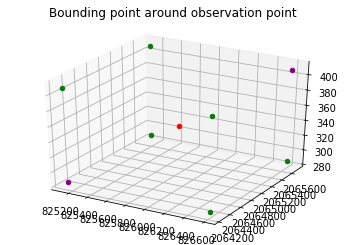

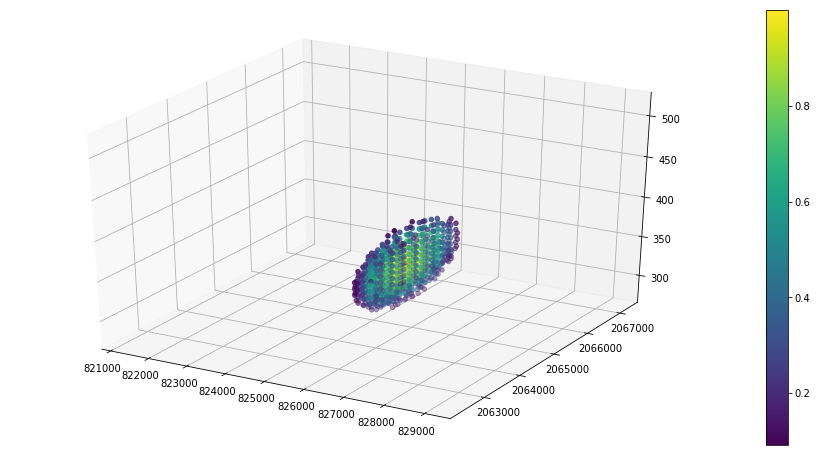

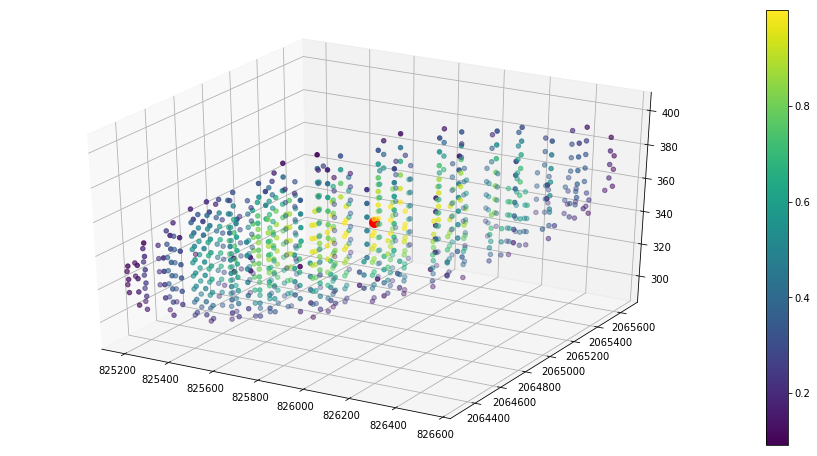

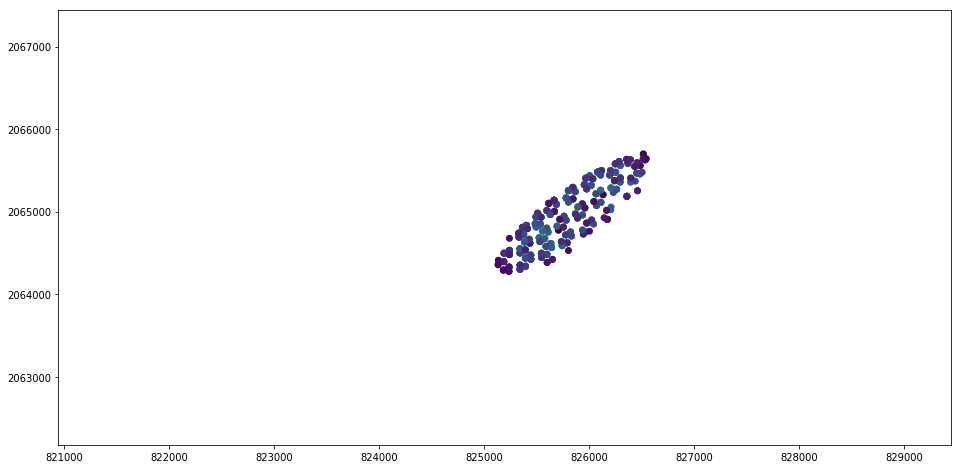

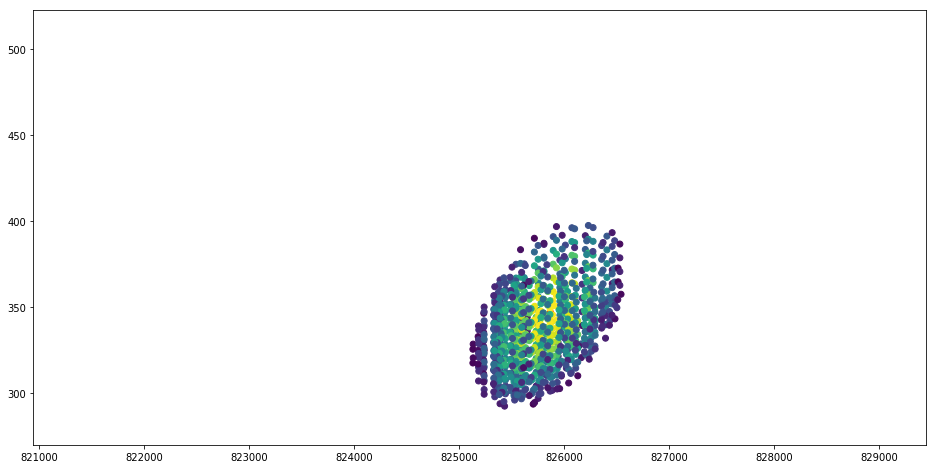

array([[2.75000000e+03, 1.69549893e-01],
       [6.07400000e+03, 2.86674539e-01],
       [6.07600000e+03, 3.48018921e-01],
       ...,
       [1.15807000e+05, 2.44298335e-01],
       [1.15821000e+05, 1.94605843e-01],
       [1.16693000e+05, 3.28058228e-01]])

In [13]:
weight_vecgeospy.weighted_updating_vector(x_obs,
                         y_obs,
                         z_obs,
                         max_range,
                         med_range,
                         min_range,
                         azimuth,
                         dip,
                         vario_type,
                         sill,
                         nugget,
                         data,
                         plot=True)